In [152]:
import numpy as np
import matplotlib.pyplot as plt 
plt.rcParams['figure.facecolor'] = "white"

from reservoir import reservoir as res
from data import data
from error import error

from reservoir.reservoir import modify_node

Generate some test data.

In [153]:
# time step size
DEL_T = 0.01
LAMBDA = 0.9056

In [154]:
lorenz_data = data.generate_lorenz_63(params=[10, 28, -8/3], 
                                      initial_state=[1, 1, 1], del_t=DEL_T,
                                      steps=30000, washout=10000)
print(lorenz_data)
print(lorenz_data.shape)
training_data = lorenz_data[:lorenz_data.shape[0] // 2]
test_data = lorenz_data[lorenz_data.shape[0] // 2:]

[[ -8.47965722 -14.5123554   15.72421705]
 [ -9.09696196 -15.40313805  16.60822317]
 [ -9.73928527 -16.26936278  17.64384007]
 ...
 [ -9.63164986  -0.84252354  36.6800054 ]
 [ -8.75710572  -0.08145599  35.7558209 ]
 [ -7.90106831   0.52294291  34.79606715]]
(20000, 3)


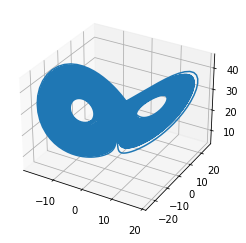

In [155]:
fig = plt.figure()
ax = plt.axes(projection="3d")
plt.plot(
    lorenz_data[:, 0],
    lorenz_data[:, 1],
    lorenz_data[:, 2]
)

Define hyperparameters, number of reservoir nodes ($N$), and the dimension of 
the input signal ($d$).

In [156]:
hyperparams = {
    'GAMMA': 7.7,
    'SIGMA': 0.81,
    'RHO_IN': 0.37,
    'K': 3,
    'RHO_R': 0.41
}

# number of reservoir nodes
N = 300
# dimension of input signal
d = 3

Construct internal connection network and input signal connection network. 

In [157]:
W_in = res.generate_W_in(hyperparams=hyperparams, shape=(N, d), seed=1)
# print(W_in)
W_r = res.generate_W_r(hyperparams=hyperparams, shape=(N, N), seed=1)
# print(W_r)

Train reservoir on training data points. 

Suppose we have a training data set 
$$
    \mathcal{U} = (\mathbf{u}(\tau_0), \dots \mathbf{u}(\tau_n))
$$
where each $\mathbf{u}_i \in \reals^3$ and $\tau_0,\dots,\tau_n$ are the time steps. 

Construct the reservoir 
$$
    \mathcal{R} = (\mathbf{r}(\tau_0), \dots \mathbf{r}(\tau_n))
$$
using:
$$
    \mathbf{r}(\tau_0) = W_{\text{in}} \mathbf{u}(\tau_0)
$$
and 
$$
    \mathbf{r}(\tau_{n+1}) = \mathbf{r}(\tau_n) + \dot{\mathbf{r}}(\tau_n)\Delta \tau.
$$

In [158]:
# compute number of time steps
n = training_data.shape[0]

# initial signal
u_0 = training_data[0]
# initial reservoir state
r_0 = np.dot(W_in, u_0)

# initialise echo state network
training_res = np.ndarray((n, N))
# fill in echo state network
for i in range(n):
    # first reservoir is unique (as it has no previous state)
    if i == 0:
        training_res[i] = r_0
    # next reservoir is dependent on reservoir dynamics
    else: 
        training_res[i] = res.next_training_node(
            r_prev=training_res[i-1],
            u_prev=training_data[i-1],
            hyperparams=hyperparams,
            W_r=W_r,
            W_in=W_in,
            delta_t=DEL_T
        )

Given a reservoir $\mathcal{R}$, we compute 
$$
    \tilde{\mathcal{R}} = (\tilde{\mathbf{r}}(\tau_0), \dots \tilde{\mathbf{r}}(\tau_n))
$$
where the components of any $\tilde{\mathbf{r}}(\tau_k)$ are given by:
$$
    \tilde{r}_i(\tau_k) = \begin{cases}
        r_i(\tau_k)      &\quad\text{if $i \leq \frac{N}{2}$} \\
        r_i(\tau_k)^2    &\quad\text{if $i > \frac{N}{2}$}
    \end{cases}
$$

In [159]:
# modify training reservoir network to account for symmetry
modified_training_res = np.ndarray((n, N))

for k in range(n):
    modified_training_res[k] = modify_node(training_res[k])

modified_training_res

array([[-0.55766738,  3.94121335, -8.07947376, ...,  0.04433093,
         0.09838741,  1.82904647],
       [-0.58120837,  3.71473429, -7.53435425, ...,  0.04256825,
         0.08208859,  1.7122324 ],
       [-0.6022072 ,  3.50569591, -7.03120896, ...,  0.04135769,
         0.06987629,  1.61593986],
       ...,
       [-0.99351978, -0.91674909, -0.40723556, ...,  0.10050252,
         0.1694306 ,  0.97204381],
       [-0.99401875, -0.92315929, -0.45284679, ...,  0.10655808,
         0.2031146 ,  0.97418199],
       [-0.9944793 , -0.92907587, -0.49497261, ...,  0.11161629,
         0.23835818,  0.97615752]])

In [160]:
test_res = res.generate_training_reservoir(
    data=training_data,
    hyperparams=hyperparams,
    W_r=W_r,
    W_in=W_in,
    delta_t=DEL_T,
)
print(sum(sum(modified_training_res - test_res)))

0.0


In [161]:
# design matrix
X = test_res
# Tikhonov regularisation parameter
ALPHA = 0.01
# analytic solution
W_out = np.dot(np.dot(np.linalg.inv(np.dot(X.transpose(), X) + ALPHA * np.identity(N)), X.transpose()), training_data)

In [162]:
test_W_out = res.generate_W_out(
    data=training_data,
    res=X,
    alpha=ALPHA
)

In [163]:
sum(sum(W_out.transpose() - test_W_out))

0.0

In [164]:
preds = np.ndarray((n, d))
for i in range(n):
    preds[i] = np.dot(W_out.transpose(), X[i])

In [165]:
test_preds = res.readout_network(test_res, test_W_out)

In [166]:
sum(sum(test_preds - preds))

0.0

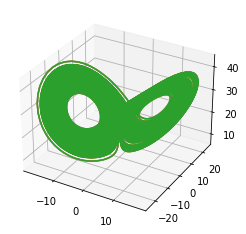

In [167]:
fig = plt.figure()
ax = plt.axes(projection="3d")
plt.plot(
    training_data[:, 0],
    training_data[:, 1],
    training_data[:, 2]
)
plt.plot(
    test_preds[:, 0],
    test_preds[:, 1],
    test_preds[:, 2]
)
plt.plot(
    preds[:, 0],
    preds[:, 1],
    preds[:, 2]
)

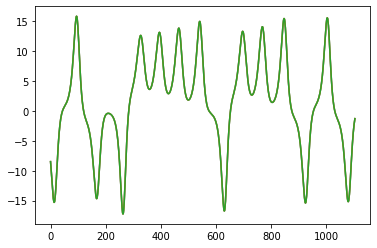

In [168]:
end = data.lyapunov_to_steps(10, LAMBDA, DEL_T)
x_range = np.array(range(end))
fig = plt.figure()
plt.plot(x_range, training_data[:end, 0])
plt.plot(x_range, test_preds[:end, 0])
plt.plot(x_range, preds[:end, 0])

In [169]:
error.RMSE(training_data, preds)

array([0.0031256 , 0.01480311, 0.01531686])

In [170]:
error.griffith_epsilon_1(
    u=training_data,
    u_hat=preds,
    delta_t=DEL_T,
    LAMBDA=0.9056
)

0.210747715443164

We have now completed the training stage, and generated:
- `X`, the reservoir generated using the training data (input signals $\mathcal{U}$)
- `W_out`, the output layer which best approximates
$$
    \mathbf{u}(\tau_n) \approx W_{\text{out}} \tilde{\mathbf{r}}(\tau_n)
$$
computed using Tikhonov regularisation. 

In the forecasting (testing) stage, we make a modification to the reservoir 
dynamics in order to make the reservoir autonomous. In particular, set the 
reservoir dynamics to:
$$
    \dot{\mathbf{r}}(t) = -\gamma \mathbf{r}(t) + \gamma \tanh(W_r \mathbf{r}(t) + W_{\text{in}}W_{\text{out}}\tilde{\mathbf{r}}(t)).
$$
and in summary, the forecast reservoir is generated using:
$$
    \mathbf{r}(\tau_0) = \mathbf{u}(\tau_0)
$$
and 
$$
    \mathbf{r}(\tau_{n+1}) = \mathbf{r}(\tau_n) + \dot{\mathbf{r}}(\tau_n)\Delta \tau.
$$

In [171]:
unmodified_test_res = res.generate_training_reservoir(
    data=training_data,
    hyperparams=hyperparams,
    W_r=W_r,
    W_in=W_in,
    delta_t=DEL_T,
    adjust_for_symmetry=False
)

In [172]:
forecast_res = res.generate_forecast_reservoir(
    r_0=unmodified_test_res[-1],
    data=test_data,
    hyperparams=hyperparams,
    W_r=W_r,
    W_in=W_in,
    W_out=test_W_out,
    delta_t=DEL_T
)
forecast_res.shape

(10000, 300)

In [173]:
forecast_res

array([[-0.9944793 , -0.92907587, -0.49497261, ...,  0.11161629,
         0.23835818,  0.97615752],
       [-0.9949044 , -0.93453678, -0.53385891, ...,  0.11544354,
         0.27444382,  0.9779825 ],
       [-0.99529676, -0.93957697, -0.56975163, ...,  0.11788245,
         0.31074747,  0.97966798],
       ...,
       [-0.9993053 , -0.98568621, -0.91774201, ...,  0.10637049,
         0.25362953,  0.99360001],
       [-0.99935878, -0.98678762, -0.92407212, ...,  0.10971481,
         0.28565078,  0.99409011],
       [-0.99940814, -0.98780392, -0.92991745, ...,  0.11220743,
         0.31801563,  0.99454197]])

In [174]:
forecast_preds = res.readout_network(forecast_res, test_W_out)
forecast_preds

array([[16.96126964, 16.52617064, 39.2271895 ],
       [16.81375994, 14.32933493, 40.76778123],
       [16.46228615, 11.97942891, 41.86253031],
       ...,
       [14.89106559, 15.42619187, 35.16469715],
       [14.880728  , 14.11772483, 36.41458398],
       [14.73870727, 12.66782152, 37.4189714 ]])

In [175]:
test_data

array([[16.82101729, 14.33395104, 40.82405288],
       [16.47078011, 11.96846906, 41.91345855],
       [15.92524358,  9.54874678, 42.5319412 ],
       ...,
       [-9.63164986, -0.84252354, 36.6800054 ],
       [-8.75710572, -0.08145599, 35.7558209 ],
       [-7.90106831,  0.52294291, 34.79606715]])

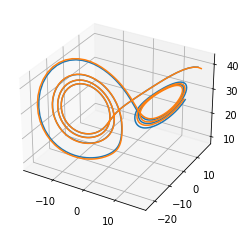

In [176]:
fig = plt.figure()
ax = plt.axes(projection="3d")
plt.plot(
    test_data[:500, 0],
    test_data[:500, 1],
    test_data[:500, 2]
)
plt.plot(
    forecast_preds[:500, 0],
    forecast_preds[:500, 1],
    forecast_preds[:500, 2]
)

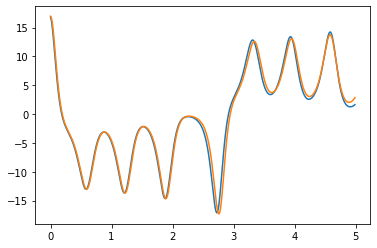

In [177]:
end = data.lyapunov_to_steps(5, LAMBDA, DEL_T)
x_range = LAMBDA * DEL_T * np.array(range(end))
fig = plt.figure()
plt.plot(x_range, test_data[:end, 0])
plt.plot(x_range, forecast_preds[:end, 0])

In [178]:
one_lyapunov = data.lyapunov_to_steps(1, LAMBDA, DEL_T)
print(error.RMSE(test_data[:one_lyapunov], forecast_preds[:one_lyapunov]))
print(error.griffith_epsilon_1(test_data, forecast_preds, DEL_T, LAMBDA=LAMBDA))

[0.47675961 0.7290641  0.69645635]
0.9879769441047872


As seen above, the reservoir computer works great when the forecast period 
immediately follows the training period. But what if the forecast period has a 
completely unrelated initial condition? 

In [179]:
seed = 42
state = np.random.RandomState(seed)
u_0 = state.choice(np.arange(-50, 50), 3)
unrelated_test_data = data.generate_lorenz_63(
    initial_state=u_0,
    del_t = DEL_T,
    steps=30000,
    washout=20000
)

In [180]:
unrelated_forecast_res = res.generate_forecast_reservoir(
    r_0=np.dot(W_in, u_0),
    data=unrelated_test_data,
    hyperparams=hyperparams,
    W_r=W_r,
    W_in=W_in,
    W_out=test_W_out,
    delta_t=DEL_T
)

In [181]:
unrelated_forecast_preds = res.readout_network(unrelated_forecast_res, test_W_out)
unrelated_forecast_preds

array([[ -13.93441099, 1001.77182437, -774.98588271],
       [  -8.6416926 ,  884.78755316, -674.47747682],
       [  -4.2216979 ,  783.52854284, -587.65568177],
       ...,
       [ -15.21789062,  -18.24539681,   33.01894245],
       [ -15.4535869 ,  -17.15760228,   34.82918753],
       [ -15.55102384,  -15.80637398,   36.44174943]])

In [182]:
unrelated_test_data

array([[ 14.16475381,  18.52826145,  29.66183586],
       [ 14.55536448,  17.97542294,  31.47205284],
       [ 14.8434437 ,  17.16016003,  33.19655074],
       ...,
       [ -9.80317198, -13.66286901,  23.07586853],
       [-10.18627551, -13.97927173,  23.83265705],
       [-10.55986793, -14.22833382,  24.65022705]])

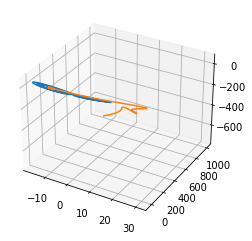

In [183]:
fig = plt.figure()
ax = plt.axes(projection="3d")
plt.plot(
    unrelated_test_data[:500, 0],
    unrelated_test_data[:500, 1],
    unrelated_test_data[:500, 2]
)
plt.plot(
    unrelated_forecast_preds[:500, 0],
    unrelated_forecast_preds[:500, 1],
    unrelated_forecast_preds[:500, 2]
)

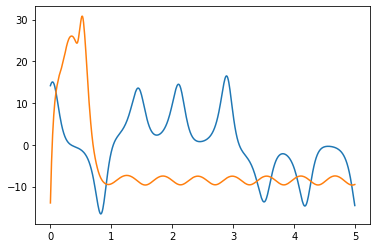

In [184]:
end = data.lyapunov_to_steps(5, LAMBDA, DEL_T)
x_range = LAMBDA * DEL_T * np.array(range(end))
fig = plt.figure()
plt.plot(x_range, unrelated_test_data[:end, 0])
plt.plot(x_range, unrelated_forecast_preds[:end, 0])

It performs poorly. We will need to optimise parameters. 